# Stack Overflow Multilabel Classification

In [364]:
import matplotlib.pyplot as plt
import os
import re
import string
import tensorflow as tf

from pathlib import Path
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers, losses

# Multilabel Classification (Dataset: StackOverflow)

## Dataset Fetch

In [5]:
dataset_url = "https://storage.googleapis.com/iobruno/datasets/stack_overflow_16k_pt-br.zip"

In [6]:
datasets_dir = Path(os.path.abspath('')).parent.joinpath('datasets')
datasets_dir.mkdir(parents=True, exist_ok=True)

In [10]:
dataset = tf.keras.utils.get_file(fname="stack_overflow_16k_pt-br.zip", 
                                  origin=dataset_url,
                                  extract=True,
                                  cache_dir=datasets_dir,
                                  cache_subdir='')

12345344/12337440 [==============================] - 0s 0us/step


In [11]:
so_dataset_dir = datasets_dir.joinpath("stack_overflow_16k")

In [12]:
so_train_dataset = so_dataset_dir.joinpath("train")
so_test_dataset = so_dataset_dir.joinpath("test")

In [14]:
os.listdir(so_train_dataset)

['python', 'java', 'csharp', 'javascript']

## Dataset Load

In [15]:
"""
Loads the Dataset in Batches/Lists of 32 entries each,
meaning that each iteration over the dataset will return 32 reviews
"""
batch_size = 32
seed = 42

### Loading Training Dataset

In [32]:
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    directory=so_train_dataset,
    batch_size=batch_size,
    seed=seed,
    validation_split=0.2,
    subset='training'
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


### Analysis of the Training Dataset

In [47]:
raw_train_ds.class_names

['csharp', 'java', 'javascript', 'python']

In [49]:
for t_corpus, t_label in raw_train_ds.take(1):
    for i in range(5):
        label  = t_label.numpy()[i]
        class_name = raw_train_ds.class_names[label]
        corpus = t_corpus.numpy()[i]
        print(f"Row: {i}")
        print(f"Class Label: {label} ({class_name})")
        print(f"Review: {corpus}")
        print()

Row: 0
Class Label: 2 (javascript)
Review: b'"Ol\xc3\xa1, gostaria de saber como pegar o caminho de uma imagem contida no value de um input do tipo  file. Estou a usar o seguinte c\xc3\xb3digo:\r\n\r\n\r\n$(document).on("change",\'#Upload\',function(){\r\n         var valor=$(this).attr(\'value\');\r\n         var ext= (valor.substring(valor.lastIndexOf("."))).toLowerCase();\r\n     if (ext==".jpg" || ext==".jpeg"){         \r\n         $("#Image").attr("src", valor);\r\n     }else{alert(\'Extensao "\'+ext+\'" nao permitida!\');}\r\n});\r\n\r\n\r\nEle retorna um fakepath, ou seja, um caminho falso. algu\xc3\xa9m poderia me ajudar?\r\n"'

Row: 1
Class Label: 0 (csharp)
Review: b'"Essa d\xc3\xbavida surgiu a partir desse post Enviar dados para uma ActionResult de um Controller diferente do atual respondido pelo Tiago S, atualmente tenho essa ActionResult que faz download de arquivo atrav\xc3\xa9s de um Post em uma View e preciso fazer atrav\xc3\xa9s do $.ajax():\r\n\r\n $(document).ready

### Loading Validation Dataset

In [51]:
raw_validation_ds = tf.keras.preprocessing.text_dataset_from_directory(
    directory=so_train_dataset,
    batch_size=batch_size,
    seed=seed,
    validation_split=0.2,
    subset='validation'
)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


### Loading Test Dataset

In [52]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    directory=so_test_dataset,
    batch_size=batch_size,
    seed=seed
)

Found 8000 files belonging to 4 classes.


## Dataset Preprocessing

### Standarization Function

In [301]:
def standardize_fn(input_data):
    lowercase_corpus = tf.strings.lower(input_data)
    newline_to_space = tf.strings.regex_replace(input=lowercase_corpus, 
                                    pattern='[\\n\\r\\t]+', 
                                    rewrite=' ')
    return tf.strings.regex_replace(input=newline_to_space, 
                                    pattern='[%s]+' % re.escape(string.punctuation), 
                                    rewrite=' ')

### Tokenization and Vectorization

In [302]:
"""Define the size of the vocabulary (the max number of words to be tokenized)"""
vocabulary_size = 10000000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=standardize_fn,
    max_tokens=vocabulary_size,
    output_mode='int',
    output_sequence_length=sequence_length    
)

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

### Testing & Visualization

In [322]:
train_text = raw_train_ds.map(lambda text, class_label: text)

In [323]:
vectorize_layer.adapt(train_text)

In [324]:
corpus_batch, label_batch = next(iter(raw_train_ds))

In [325]:
post, label = corpus_batch[0], label_batch[0]

In [326]:
print("Pre-processing Post: ", post)

Pre-processing Post:  tf.Tensor(b'"Estou utilizando DefaultHttpClient para fazer requisi\xc3\xa7\xc3\xb5es em json de um Webservice, por\xc3\xa9m esta fun\xc3\xa7\xc3\xa3o est\xc3\xa1 obsoleta, qual a melhor alternativa para a cria\xc3\xa7\xc3\xa3o de um cliente para Webservice?\r\n"', shape=(), dtype=string)


In [327]:
print("Post-processing Post: ", standardize_fn(post))

Post-processing Post:  tf.Tensor(b' estou utilizando defaulthttpclient para fazer requisi\xc3\xa7\xc3\xb5es em json de um webservice  por\xc3\xa9m esta fun\xc3\xa7\xc3\xa3o est\xc3\xa1 obsoleta  qual a melhor alternativa para a cria\xc3\xa7\xc3\xa3o de um cliente para webservice   ', shape=(), dtype=string)


In [331]:
print("Label: ", raw_train_ds.class_names[label])

Label:  java


In [333]:
print("Vectorized Post: ", vectorize_text(post, label))

Vectorized Post:  (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   28,   280, 10249,    11,    50,  2867,    14,   143,     4,
            8,   880,   105,   217,   128,    80, 24632,   174,     3,
          480,  3154,    11,     3,  1778,     4,     8,   111,    11,
          880,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
          

### Applying Vectorization to Training/Validation/Test Datasets

In [335]:
train_ds = raw_train_ds.map(vectorize_text)
validation_ds = raw_validation_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Caching Datasets to RAM

In [336]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds.cache().prefetch(buffer_size=AUTOTUNE)

<PrefetchDataset shapes: ((None, 250), (None,)), types: (tf.int64, tf.int32)>

## Model Training

### Model Parametrization

In [337]:
embedding_dim = 16

In [339]:
model = tf.keras.Sequential([
    layers.Embedding(vocabulary_size+1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(4)
])

In [340]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000016 
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 68        
Total params: 160,000,084
Trainable params: 160,000,084
Non-trainable params: 0
_________________________________________________________________


In [347]:
model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=tf.metrics.BinaryAccuracy(threshold=0.0)
)

### Model Training

In [350]:
epochs = 1

In [351]:
history = model.fit(train_ds,
                    validation_data=validation_ds,
                    epochs=epochs)

200/200 [==============================] - 483s 2s/step - loss: 1.3671 - binary_accuracy: 0.2441 - val_loss: 1.3464 - val_binary_accuracy: 0.2355


### Model Evaluation

In [352]:
loss, accuracy = model.evaluate(test_ds)

250/250 [==============================] - 4s 15ms/step - loss: 1.3376 - binary_accuracy: 0.2336


In [353]:
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

Loss: 1.3375530242919922
Accuracy: 0.23356249928474426


In [359]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [360]:
bin_acc = history_dict['binary_accuracy']
validation_acc = history_dict['val_binary_accuracy']

In [361]:
loss = history_dict['loss']
validation_loss = history_dict['val_loss']

In [362]:
epochs = range(1, len(bin_acc) + 1)

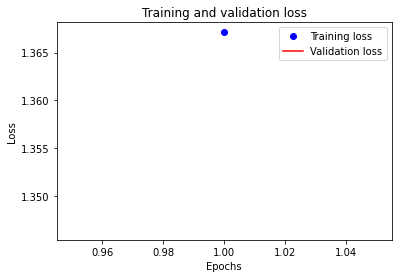

In [366]:
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, validation_loss, 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

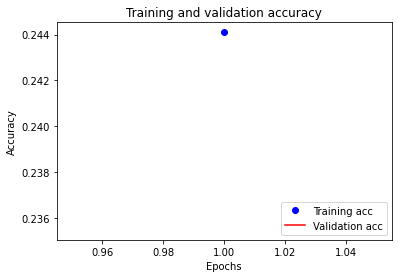

In [368]:
plt.plot(epochs, bin_acc, 'bo', label='Training acc')
plt.plot(epochs, validation_acc, 'red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()